<img src="img/header.png" style="width:100%">

<h1 style="font-size: 2.5em; background-color: #DC7D2D; padding: 1em">Problem Definition</h1>

This Notebook train and deploy machine learning models for predicting parents' satisfaction with their kindergartens. It presents a set of predictive models that can help parents select a good kindergarten in the Oslo Urban Area, based on three parameters:

* Quality of the Outdoors area
* Quality of toys available to the children
* Quality of the food served

To train the models, the notebook makes use of the Norwegian Parent Survey for kindergartens, which is a publicly available dataset about how happy parents are with their kindergarten services (for more information see <a href="https://www.udir.no/tall-og-forskning/brukerundersokelser/administrere-foreldreundersokelsen-for-barnehage/forberede/informer-foreldre/engelsk/">link</a>). Since a number of kindergartens are - for various reasons - not included this public statistic, there is a need for some way of estimating the parent satisfaction level at these kindergartens. This is the use-case for the machine learning models presented in this Notebook.

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

<h1 style="font-size: 2.5em; background-color: #DC7D2D; padding: 1em">Importing data</h1>

* The data is taken from the Norwegian Parent Survey for kindergartens. The Parent Survey for kindergartens is a survey that gives parents an opportunity to state how they feel about the kindergarten services. The survey allows the kindergartens and their owners to know how satisfied parents are with the services that the kindergartens provide.

* The survey is carried out every year and include parents all across the country. However, in the dataset for this project, we will only make use of data for 2022, and we will only include kindergartens in counties that belong to the Oslo Urban Area. That is, we will only include kindergartens that are in the capital of Norway or the surrounding area.

* The survey consists of 30 questions that allow the parents to express their opinion about different aspects of the kindergarten services. However, in our dataset, we only include three questions: how the parents perceive (1) the outdoors playing area, (2) the toys available to the kids and (3) the quality of the food served.

* The survey data is published as aggregate numbers for each kindergarten (and municipality, county), and their score on each question is therefore an average of what the parents thought about the kindergarten's services.

* The survey also includes some background information about the kindergartens such as whether they are public or private, their size (measured in number of kids) and location.

* The data can be found following this <a href="https://www.udir.no/tall-og-forskning/statistikk/statistikk-barnehage/foreldreundersokelsen-i-barnehager--resultater-etter-fylke/?rapportsideKode=BHG_Fuba_Fylk&filtre=AldergruppeID(-10)_BarnehageenhetID(-12)_BarnehagestoerrelsegruppeID(-10)_KjoennID(-10)_KommunalitetID(-10)_SpoersmaalID(-31_-30_-29_-28_-27_-26_-25_-24_-23)_TidID(202212)_VisAntallBesvart(0)&radsti=F!(1)_(*)_(1.*)">link</a>

In [2]:
df = pd.read_csv("data/kindergarten.csv", encoding="utf16", sep="\t")

In [3]:
df

,BarnehageenhetNivaa,Nasjonaltkode,Fylkekode,Kommunekode,Organisasjonsnummer,Nasjonalt,Fylke,Kommune,Barnehageenhetnavn,2022.1 - 25 barn.Kommunal.Alle aldersgrupper.Ute- og innemiljø.Utearealer.Snittsvar,2022.1 - 25 barn.Kommunal.Alle aldersgrupper.Ute- og innemiljø.Leker og utstyr.Snittsvar,2022.1 - 25 barn.Kommunal.Alle aldersgrupper.Ute- og innemiljø.Mattilbudet.Snittsvar,2022.1 - 25 barn.Privat.Alle aldersgrupper.Ute- og innemiljø.Utearealer.Snittsvar,2022.1 - 25 barn.Privat.Alle aldersgrupper.Ute- og innemiljø.Leker og utstyr.Snittsvar,2022.1 - 25 barn.Privat.Alle aldersgrupper.Ute- og innemiljø.Mattilbudet.Snittsvar,2022.26 - 50 barn.Kommunal.Alle aldersgrupper.Ute- og innemiljø.Utearealer.Snittsvar,2022.26 - 50 barn.Kommunal.Alle aldersgrupper.Ute- og innemiljø.Leker og utstyr.Snittsvar,2022.26 - 50 barn.Kommunal.Alle aldersgrupper.Ute- og innemiljø.Mattilbudet.Snittsvar,2022.26 - 50 barn.Privat.Alle aldersgrupper.Ute- og innemiljø.Utearealer.Snittsvar,2022.26 - 50 barn.Privat.Alle aldersgrupper.Ute- og innemiljø.Leker og utstyr.Snittsvar,2022.26 - 50 barn.Privat.Alle aldersgrupper.Ute- og innemiljø.Mattilbudet.Snittsvar,2022.51 - 75 barn.Kommunal.Alle aldersgrupper.Ute- og innemiljø.Utearealer.Snittsvar,2022.51 - 75 barn.Kommunal.Alle aldersgrupper.Ute- og innemiljø.Leker og utstyr.Snittsvar,2022.51 - 75 barn.Kommunal.Alle aldersgrupper.Ute- og innemiljø.Mattilbudet.Snittsvar,2022.51 - 75 barn.Privat.Alle aldersgrupper.Ute- og innemiljø.Utearealer.Snittsvar,2022.51 - 75 barn.Privat.Alle aldersgrupper.Ute- og innemiljø.Leker og utstyr.Snittsvar,2022.51 - 75 barn.Privat.Alle aldersgrupper.Ute- og innemiljø.Mattilbudet.Snittsvar,2022.76 + barn.Kommunal.Alle aldersgrupper.Ute- og innemiljø.Utearealer.Snittsvar,2022.76 + barn.Kommunal.Alle aldersgrupper.Ute- og innemiljø.Leker og utstyr.Snittsvar,2022.76 + barn.Kommunal.Alle aldersgrupper.Ute- og innemiljø.Mattilbudet.Snittsvar,2022.76 + barn.Privat.Alle aldersgrupper.Ute- og innemiljø.Utearealer.Snittsvar,2022.76 + barn.Privat.Alle aldersgrupper.Ute- og innemiljø.Leker og utstyr.Snittsvar,2022.76 + barn.Privat.Alle aldersgrupper.Ute- og innemiljø.Mattilbudet.Snittsvar
0,1,I,NaN,NaN,I,Hele landet,Alle fylker,Alle kommuner,Alle barnehager,"4,1","4,2","3,9","4,3","4,4","4,4","4,0","4,1","3,7","4,2","4,3","4,2","4,0","4,1","3,6","4,2","4,3","4,1","4,0","4,1","3,6","4,2","4,3","4,2"
1,2,I,3.0,NaN,03,Hele landet,Oslo,Alle kommuner,Alle barnehager,"4,0","4,1","3,6","4,1","4,4","4,3","3,8","4,1","3,6","4,2","4,3","4,1","3,9","4,1","3,4","4,0","4,3","4,1","4,0","4,1","3,4","4,0","4,3","4,2"
2,3,I,3.0,30112.0,030112,Hele landet,Oslo,Alna,Alle barnehager,"4,3","4,4","4,4","4,3","4,3","3,6","3,7","3,9","3,3","4,4","4,3","4,3","3,7","3,9","3,7","3,8","4,1","4,0","4,1","4,1","3,6","3,8","4,1","3,9"
3,4,I,3.0,30112.0,996797864,Hele landet,Oslo,Alna,Barneslottet barnehage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"4,3","4,1","3,7",NaN,NaN,NaN
4,4,I,3.0,30112.0,973111965,Hele landet,Oslo,Alna,Fresesarmeens barnehager Teisentopp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"3,8","4,0","3,9"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,4,I,30.0,3027.0,987067276,Hele landet,Viken,Rælingen,Smestadtoppen barnehage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"4,1","4,1","3,6",NaN,NaN,NaN
866,4,I,30.0,3027.0,872215492,Hele landet,Viken,Rælingen,Tangen barnehage SA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"4,3","4,5","3,4",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
867,4,I,30.0,3027.0,991298207,Hele landet,Viken,Rælingen,Tomter Fus barnehage AS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"4,2","4,2","3,8",NaN,NaN,NaN,NaN,NaN,NaN
868,4,I,30.0,3027.0,988860298,Hele landet,Viken,Rælingen,Torva barnehage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"3,3","3,8","3,0",NaN,NaN,NaN,NaN,NaN,NaN,NaN,

<h1 style="font-size: 2.5em; background-color: #DC7D2D; padding: 1em">Data cleaning</h1>

The dataset comes in a form that requires a considerable amount of data wrangling to make it ready for any type of analysis. In this section, we will carry out the following operations:

* Remove unnecessary aggregates
* Translate Norwegian terms to English
* Compress sparse data into a smaller number of columns
* Change European decimal notation with ',' to American notation with '.'

In [4]:
# Remove all rows that are aggregates for city districts, the municipalitity, the county or the country. 
# This is done by removing all BarnehageenhetNivaa < 4

mask = df["BarnehageenhetNivaa"] == 4
df = df[mask]

In [5]:
transformation_dict = {
       'Organisasjonsnummer': 'Company registration number',
       'Kommune': 'Borough of Oslo',
       'Barnehageenhetnavn': 'Kindergarden Name',
       '2022.1 - 25 barn.Kommunal.Alle aldersgrupper.Ute- og innemiljø.Utearealer.Snittsvar': '1-25_Public_Outdoors',
       '2022.1 - 25 barn.Kommunal.Alle aldersgrupper.Ute- og innemiljø.Leker og utstyr.Snittsvar': '1-25_Public_Toys',
       '2022.1 - 25 barn.Kommunal.Alle aldersgrupper.Ute- og innemiljø.Mattilbudet.Snittsvar': '1-25_Public_Food',
       '2022.1 - 25 barn.Privat.Alle aldersgrupper.Ute- og innemiljø.Utearealer.Snittsvar': '1-25_Private_Outdoors',
       '2022.1 - 25 barn.Privat.Alle aldersgrupper.Ute- og innemiljø.Leker og utstyr.Snittsvar': '1-25_Private_Toys',
       '2022.1 - 25 barn.Privat.Alle aldersgrupper.Ute- og innemiljø.Mattilbudet.Snittsvar': '1-25_Private_Food',
       '2022.26 - 50 barn.Kommunal.Alle aldersgrupper.Ute- og innemiljø.Utearealer.Snittsvar': '26-50_Public_Outdoors',
       '2022.26 - 50 barn.Kommunal.Alle aldersgrupper.Ute- og innemiljø.Leker og utstyr.Snittsvar': '26-50_Public_Toys',
       '2022.26 - 50 barn.Kommunal.Alle aldersgrupper.Ute- og innemiljø.Mattilbudet.Snittsvar': '26-50_Public_Food',
       '2022.26 - 50 barn.Privat.Alle aldersgrupper.Ute- og innemiljø.Utearealer.Snittsvar': '26-50_Privat_Outdoors',
       '2022.26 - 50 barn.Privat.Alle aldersgrupper.Ute- og innemiljø.Leker og utstyr.Snittsvar': '26-50_Privat_Toys',
       '2022.26 - 50 barn.Privat.Alle aldersgrupper.Ute- og innemiljø.Mattilbudet.Snittsvar': '26-50_Privat_Food',
       '2022.51 - 75 barn.Kommunal.Alle aldersgrupper.Ute- og innemiljø.Utearealer.Snittsvar': '51-75_Public_Outdoors',
       '2022.51 - 75 barn.Kommunal.Alle aldersgrupper.Ute- og innemiljø.Leker og utstyr.Snittsvar': '51-75_Public_Toys',
       '2022.51 - 75 barn.Kommunal.Alle aldersgrupper.Ute- og innemiljø.Mattilbudet.Snittsvar': '51-75_Public_Food',
       '2022.51 - 75 barn.Privat.Alle aldersgrupper.Ute- og innemiljø.Utearealer.Snittsvar': '51-75_Private_Outdoors',
       '2022.51 - 75 barn.Privat.Alle aldersgrupper.Ute- og innemiljø.Leker og utstyr.Snittsvar': '51-75_Private_Toys',
       '2022.51 - 75 barn.Privat.Alle aldersgrupper.Ute- og innemiljø.Mattilbudet.Snittsvar': '51-75_Private_Food',
       '2022.76 + barn.Kommunal.Alle aldersgrupper.Ute- og innemiljø.Utearealer.Snittsvar': '76+_Public_Outdoors',
       '2022.76 + barn.Kommunal.Alle aldersgrupper.Ute- og innemiljø.Leker og utstyr.Snittsvar': '76+_Public_Toys',
       '2022.76 + barn.Kommunal.Alle aldersgrupper.Ute- og innemiljø.Mattilbudet.Snittsvar': '76+_Public_Food',
       '2022.76 + barn.Privat.Alle aldersgrupper.Ute- og innemiljø.Utearealer.Snittsvar': '76+_Private_Outdoors',
       '2022.76 + barn.Privat.Alle aldersgrupper.Ute- og innemiljø.Leker og utstyr.Snittsvar': '76+_Private_Toys',
       '2022.76 + barn.Privat.Alle aldersgrupper.Ute- og innemiljø.Mattilbudet.Snittsvar': '76+_Private_Food'
}

In [6]:
df = df.rename(columns=transformation_dict)

In [7]:
df.columns

Index(['BarnehageenhetNivaa', 'Nasjonaltkode', 'Fylkekode', 'Kommunekode',
       'Company registration number', 'Nasjonalt', 'Fylke', 'Borough of Oslo',
       'Kindergarden Name', '1-25_Public_Outdoors', '1-25_Public_Toys',
       '1-25_Public_Food', '1-25_Private_Outdoors', '1-25_Private_Toys',
       '1-25_Private_Food', '26-50_Public_Outdoors', '26-50_Public_Toys',
       '26-50_Public_Food', '26-50_Privat_Outdoors', '26-50_Privat_Toys',
       '26-50_Privat_Food', '51-75_Public_Outdoors', '51-75_Public_Toys',
       '51-75_Public_Food', '51-75_Private_Outdoors', '51-75_Private_Toys',
       '51-75_Private_Food', '76+_Public_Outdoors', '76+_Public_Toys',
       '76+_Public_Food', '76+_Private_Outdoors', '76+_Private_Toys',
       '76+_Private_Food'],
      dtype='object')

In [8]:
# Remove unneccesary columns

df = df[['Company registration number', 'Borough of Oslo','Kindergarden Name', 
    '1-25_Public_Outdoors', '1-25_Public_Toys','1-25_Public_Food', '1-25_Private_Outdoors', '1-25_Private_Toys','1-25_Private_Food', 
    '26-50_Public_Outdoors', '26-50_Public_Toys','26-50_Public_Food', '26-50_Privat_Outdoors', '26-50_Privat_Toys', '26-50_Privat_Food', 
    '51-75_Public_Outdoors', '51-75_Public_Toys','51-75_Public_Food', '51-75_Private_Outdoors', '51-75_Private_Toys','51-75_Private_Food', 
    '76+_Public_Outdoors', '76+_Public_Toys','76+_Public_Food', '76+_Private_Outdoors', '76+_Private_Toys','76+_Private_Food']]

In [9]:
df

,Company registration number,Borough of Oslo,Kindergarden Name,1-25_Public_Outdoors,1-25_Public_Toys,1-25_Public_Food,1-25_Private_Outdoors,1-25_Private_Toys,1-25_Private_Food,26-50_Public_Outdoors,26-50_Public_Toys,26-50_Public_Food,26-50_Privat_Outdoors,26-50_Privat_Toys,26-50_Privat_Food,51-75_Public_Outdoors,51-75_Public_Toys,51-75_Public_Food,51-75_Private_Outdoors,51-75_Private_Toys,51-75_Private_Food,76+_Public_Outdoors,76+_Public_Toys,76+_Public_Food,76+_Private_Outdoors,76+_Private_Toys,76+_Private_Food
3,996797864,Alna,Barneslottet barnehage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"4,3","4,1","3,7",NaN,NaN,NaN
4,973111965,Alna,Fresesarmeens barnehager Teisentopp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"3,8","4,0","3,9"
5,975317161,Alna,Frydenlund barnehage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"3,9","3,9","3,3",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,975317145,Alna,Furustien barnehage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"3,7","3,9","3,9",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,893765832,Alna,Gransbakken barnehage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"3,9","4,0","3,2",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,987067276,Rælingen,Smestadtoppen barnehage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"4,1","4,1","3,6",NaN,NaN,NaN
866,872215492,Rælingen,Tangen barnehage SA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"4,3","4,5","3,4",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
867,991298207,Rælingen,Tomter Fus barnehage AS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"4,2","4,2","3,8",NaN,NaN,NaN,NaN,NaN,NaN
868,988860298,Rælingen,Torva barnehage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"3,3","3,8","3,0",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Functions to compress data into fewer rows

def public_vs_private(rows):
    public_vs_private = 'public'
    for element in rows:
        if pd.notnull(element):
            public_vs_private = 'private'
    return public_vs_private


def size_of_kindergarden(rows):
    size_of_kindergarden = None
    for number, element in enumerate(rows):
        if pd.notnull(element):
            
            if number == 0 or number == 1:
                if size_of_kindergarden != None and size_of_kindergarden != '1-25':
                    raise Exception("Kindergarden can only have one size. Check input columns!")
                else:
                    size_of_kindergarden = '1-25'
            
            if number == 2 or number == 3:
                if size_of_kindergarden != None and size_of_kindergarden != '26-50':
                    raise Exception("Kindergarden can only have one size. Check input columns!")
                else:
                    size_of_kindergarden = '26-50'
            
            if number == 4 or number == 5:
                if size_of_kindergarden != None and size_of_kindergarden != '51-75':
                    raise Exception("Kindergarden can only have one size. Check input columns!")
                else:
                    size_of_kindergarden = '51-75'
            
            if number == 6 or number == 7:
                if size_of_kindergarden != None and size_of_kindergarden != '76+':
                    raise Exception("Kindergarden can only have one size. Check input columns!")
                else:
                    size_of_kindergarden = '76+'
    
    return size_of_kindergarden


def score_on_category(rows):
    
    score_on_category = None 
    
    list_of_elements = [element for element in rows if pd.notnull(element)]
    if len(list_of_elements) > 1:
        raise Exception("Kindergardens can only have one score for each category. Check input columns!")
    else:
        score_on_category = list_of_elements[0]
    
    return score_on_category

In [11]:
df['Ownership'] = df[[
    '1-25_Private_Outdoors', '1-25_Private_Toys','1-25_Private_Food', 
    '26-50_Privat_Outdoors', '26-50_Privat_Toys', '26-50_Privat_Food', 
    '51-75_Private_Outdoors', '51-75_Private_Toys','51-75_Private_Food', 
    '76+_Private_Outdoors', '76+_Private_Toys','76+_Private_Food'
]].apply(public_vs_private, axis=1)

In [12]:
df['Size'] = df[[
    '1-25_Public_Outdoors', '1-25_Private_Outdoors',
    '26-50_Public_Outdoors', '26-50_Privat_Outdoors',
    '51-75_Public_Outdoors', '51-75_Private_Outdoors',
    '76+_Public_Outdoors', '76+_Private_Outdoors'
]].apply(size_of_kindergarden, axis=1)

In [13]:
df['Outdoors_score'] = df[[
    '1-25_Public_Outdoors','1-25_Private_Outdoors', '26-50_Public_Outdoors', '26-50_Privat_Outdoors', 
    '51-75_Public_Outdoors','51-75_Private_Outdoors', '76+_Public_Outdoors','76+_Private_Outdoors'
]].apply(score_on_category, axis=1)

In [14]:
df['Toys_score'] =  df[[
    '1-25_Public_Toys', '1-25_Private_Toys', '26-50_Public_Toys', '26-50_Privat_Toys', 
    '51-75_Public_Toys', '51-75_Private_Toys', '76+_Public_Toys', '76+_Private_Toys'
]].apply(score_on_category, axis=1)

In [15]:
df['Food_score'] = df[[
    '1-25_Public_Food','1-25_Private_Food','26-50_Public_Food','26-50_Privat_Food',
    '51-75_Public_Food','51-75_Private_Food','76+_Public_Food','76+_Private_Food'  
]].apply(score_on_category, axis=1)

In [16]:
df.columns

Index(['Company registration number', 'Borough of Oslo', 'Kindergarden Name',
       '1-25_Public_Outdoors', '1-25_Public_Toys', '1-25_Public_Food',
       '1-25_Private_Outdoors', '1-25_Private_Toys', '1-25_Private_Food',
       '26-50_Public_Outdoors', '26-50_Public_Toys', '26-50_Public_Food',
       '26-50_Privat_Outdoors', '26-50_Privat_Toys', '26-50_Privat_Food',
       '51-75_Public_Outdoors', '51-75_Public_Toys', '51-75_Public_Food',
       '51-75_Private_Outdoors', '51-75_Private_Toys', '51-75_Private_Food',
       '76+_Public_Outdoors', '76+_Public_Toys', '76+_Public_Food',
       '76+_Private_Outdoors', '76+_Private_Toys', '76+_Private_Food',
       'Ownership', 'Size', 'Outdoors_score', 'Toys_score', 'Food_score'],
      dtype='object')

In [17]:
# Removing unneccesary columns
df = df[['Company registration number', 'Kindergarden Name','Outdoors_score', 'Toys_score', 'Food_score', 
         'Borough of Oslo', 'Ownership', 'Size', 
    ]]

In [18]:
# Change European decimal notation with ',' to American notation with '.'

df['Outdoors_score'] = df['Outdoors_score'].replace('*', np.nan)
df['Outdoors_score'] = df['Outdoors_score'].replace(',', '.', regex=True)
df['Outdoors_score'] = df['Outdoors_score'].astype(float)

df['Toys_score'] = df['Toys_score'].replace('*', np.nan)
df['Toys_score'] = df['Toys_score'].replace(',', '.', regex=True)
df['Toys_score'] = df['Toys_score'].astype(float)

df['Food_score'] = df['Food_score'].replace('*', np.nan)
df['Food_score'] = df['Food_score'].replace(',', '.', regex=True)
df['Food_score'] = df['Food_score'].astype(float)

In [19]:
df

,Company registration number,Kindergarden Name,Outdoors_score,Toys_score,Food_score,Borough of Oslo,Ownership,Size
3,996797864,Barneslottet barnehage,4.3,4.1,3.7,Alna,public,76+
4,973111965,Fresesarmeens barnehager Teisentopp,3.8,4.0,3.9,Alna,private,76+
5,975317161,Frydenlund barnehage,3.9,3.9,3.3,Alna,public,51-75
6,975317145,Furustien barnehage,3.7,3.9,3.9,Alna,public,51-75
7,893765832,Gransbakken barnehage,3.9,4.0,3.2,Alna,public,76+
...,...,...,...,...,...,...,...,...
865,987067276,Smestadtoppen barnehage,4.1,4.1,3.6,Rælingen,public,76+
866,872215492,Tangen barnehage SA,4.3,4.5,3.4,Rælingen,private,26-50
867,991298207,Tomter Fus barnehage AS,4.2,4.2,3.8,Rælingen,private,51-75
868,988860298,Torva barnehage,3.3,3.8,3.0,Rælingen,public,51-75


<h1 style="font-size: 2.5em; background-color: #DC7D2D; padding: 1em">Data Transformation for Analysis</h1>

We make a Data class that can transform the data and make it available for:
* Exploratory Data Analysis
* Lasso Regression 
* Random Forest and 
* Gradient boosting

In [20]:
class Data():
    
    def __init__(self, df):
        self.df = df.copy(deep=True)
        self.transform_size_dict      = {'1-25': 1, '26-50': 2, '51-75': 3, '76+': 4}
        self.transform_ownership_dict = {'public': 0, 'private': 1}
        
        self.complete_dataset = self.complete_dataset(self.df)
        
        self.outdoors_regression = self.regression(self.df[['Outdoors_score', 'Borough of Oslo', 'Ownership', 'Size']])
        self.toys_regression     = self.regression(self.df[['Toys_score', 'Borough of Oslo', 'Ownership', 'Size']])
        self.food_regression     = self.regression(self.df[['Food_score', 'Borough of Oslo', 'Ownership', 'Size']])
        
        self.outdoors_decision_tree = self.decision_tree(self.df[['Outdoors_score', 'Borough of Oslo', 'Ownership', 'Size']])
        self.toys_decision_tree     = self.decision_tree(self.df[['Toys_score', 'Borough of Oslo', 'Ownership', 'Size']])
        self.food_decision_tree     = self.decision_tree(self.df[['Food_score', 'Borough of Oslo', 'Ownership', 'Size']])
    
    
    def regression(self, df):
        df = df.copy(deep=True)
        score_column = df.columns[0]
        
        df['Ownership'] = df['Ownership'].map(self.transform_ownership_dict)
        df['Size'] = df['Size'].map(self.transform_size_dict )
        df = pd.concat([df, pd.get_dummies(df['Borough of Oslo'], drop_first=True)], axis=1)
        
        df = df[[score_column, 'Ownership', 'Size',
                 'Bjerke', 'Frogner', 'Gamle Oslo', 'Grorud', 'Grünerløkka',
                 'Nordre Aker', 'Nordstrand', 'Sagene', 'St. Hanshaugen', 'Stovner',
                 'Søndre Nordstrand', 'Ullern', 'Vestre Aker', 'Østensjø', 'Asker',
                 'Bærum', 'Lier', 'Lillestrøm', 'Lørenskog', 'Nittedal',
                 'Nordre Follo', 'Rælingen']]
        df = df.dropna()
        
        scaler = StandardScaler()
        df[['Ownership', 'Size']] = scaler.fit_transform(df[['Ownership', 'Size']])
        return df
    
    
    def decision_tree(self, df):
        df = df.copy(deep=True)
        score_column = df.columns[0]
        
        df['Ownership'] = df['Ownership'].map(self.transform_ownership_dict)
        df['Size'] = df['Size'].map(self.transform_size_dict )
        df = pd.concat([df, pd.get_dummies(df['Borough of Oslo'])], axis=1)
        df = df[[score_column, 'Ownership', 'Size',
                 'Alna', 'Bjerke', 'Frogner', 'Gamle Oslo', 'Grorud', 'Grünerløkka',
                 'Nordre Aker', 'Nordstrand', 'Sagene', 'St. Hanshaugen', 'Stovner',
                 'Søndre Nordstrand', 'Ullern', 'Vestre Aker', 'Østensjø', 'Asker',
                 'Bærum', 'Lier', 'Lillestrøm', 'Lørenskog', 'Nittedal',
                 'Nordre Follo', 'Rælingen']]
        df = df.dropna()
        return df
    
    
    def complete_dataset(self, df):
        df = df.copy(deep=True)
        
        df['Ownership'] = df['Ownership'].map(self.transform_ownership_dict)
        df['Size'] = df['Size'].map(self.transform_size_dict )
        df = pd.concat([df, pd.get_dummies(df['Borough of Oslo'])], axis=1)
        df = df[['Outdoors_score', 'Toys_score', 'Food_score', 'Ownership', 'Size',
                 'Alna', 'Bjerke', 'Frogner', 'Gamle Oslo', 'Grorud', 'Grünerløkka',
                 'Nordre Aker', 'Nordstrand', 'Sagene', 'St. Hanshaugen', 'Stovner',
                 'Søndre Nordstrand', 'Ullern', 'Vestre Aker', 'Østensjø']]
        return df
    
    
    def transform_to_tree(self, ownership, size, borough):
        df = self.outdoors_decision_tree.copy(deep=True)
        df = df.iloc[0:1, 1:]
        df = df.reset_index(drop=True)
        df.iloc[0] = 0
        
        
        df['Ownership'] = self.transform_ownership_dict[ownership]
        df['Size']      = self.transform_size_dict[size]
        df[borough]     = 1
        return df

In [21]:
data = Data(df)

<h1 style="font-size: 2.5em; background-color: #DC7D2D; padding: 1em">Exploratory Data Analysis</h1> 

In [22]:
data.complete_dataset.corr()

,Outdoors_score,Toys_score,Food_score,Ownership,Size,Alna,Bjerke,Frogner,Gamle Oslo,Grorud,Grünerløkka,Nordre Aker,Nordstrand,Sagene,St. Hanshaugen,Stovner,Søndre Nordstrand,Ullern,Vestre Aker,Østensjø
Outdoors_score,1.000000,0.632501,0.294405,0.271982,-0.066253,-0.097616,-0.050090,-0.048927,-0.175452,-0.081938,-0.104915,0.056344,0.073403,-0.110926,-0.016427,-0.026767,0.002289,-0.010475,0.069394,-0.011276
Toys_score,0.632501,1.000000,0.507943,0.401397,-0.172269,-0.122153,-0.045607,0.009105,-0.093132,-0.096601,-0.094032,0.101981,0.054777,-0.011512,0.007808,-0.060256,-0.025033,0.028439,0.040154,0.039569
Food_score,0.294405,0.507943,1.000000,0.636532,-0.242672,-0.053012,-0.054366,0.045616,-0.066206,-0.060592,-0.028535,0.103818,-0.000107,-0.046921,0.074172,0.010656,0.012680,-0.041350,0.036326,-0.053757
Ownership,0.271982,0.401397,0.636532,1.000000,-0.258092,-0.056589,-0.051368,0.011426,-0.073821,-0.103010,-0.082744,0.092720,-0.023313,-0.090414,0.038096,-0.133590,-0.069939,-0.000809,0.112776,-0.075293
Size,-0.066253,-0.172269,-0.242672,-0.258092,1.000000,-0.015134,-0.008465,-0.046382,0.035667,0.038259,0.108048,-0.022114,0.022607,-0.001628,-0.017438,-0.020116,0.013883,-0.059739,-0.052190,0.020907
Alna,-0.097616,-0.122153,-0.053012,-0.056589,-0.015134,1.000000,-0.042624,-0.047000,-0.050401,-0.033356,-0.043379,-0.059659,-0.052354,-0.042624,-0.044123,-0.041078,-0.043379,-0.048384,-0.056703,-0.049063
Bjerke,-0.050090,-0.045607,-0.054366,-0.051368,-0.008465,-0.042624,1.000000,-0.039236,-0.042075,-0.027846,-0.036213,-0.049804,-0.043706,-0.035583,-0.036835,-0.034292,-0.036213,-0.040391,-0.047336,-0.040959
Frogner,-0.048927,0.009105,0.045616,0.011426,-0.046382,-0.047000,-0.039236,1.000000,-0.046394,-0.030705,-0.039931,-0.054916,-0.048192,-0.039236,-0.040616,-0.037812,-0.039931,-0.044537,-0.052196,-0.045163
Gamle Oslo,-0.175452,-0.093132,-0.066206,-0.073821,0.035667,-0.050401,-0.042075,-0.046394,1.000000,-0.032927,-0.042820,-0.058890,-0.051680,-0.042075,-0.043555,-0.040548,-0.042820,-0.047760,-0.055973,-0.048431
Grorud,-0.081938,-0.096601,-0.060592,-0.103010,0.038259,-0.033356,-0.027846,-0.030705,-0.032927,1.000000,-0.028340,-0.038975,-0.034203,-0.027846,-0.028826,-0.026836,-0.028340,-0.031609,-0.037044,-0.032053


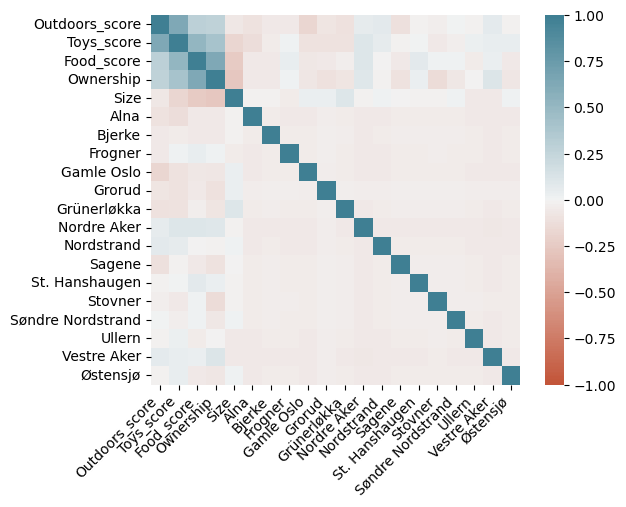

In [23]:
# inspired by Drazen Zaric in https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
corr = data.complete_dataset.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# Comments on the Correlation Matrix:

* From the correlation matrix we can see that none of the features are strongly correlated with any of the three class variables (Outdoors_score, Toys_score and Food_score). 
* However, Ownership seem to be moderate positive correlation with the Toy and Food score. That means that the quality of toys and food might on average be somewhat higher at private kindergartens. 
* Similarly, Size seems to have a moderate negative correlation with Toy and Food score. That means that the quality of toys and food might on average be somewhat lower in larger kindergartens.
* The correlations between Outdoors area and other features are small.
* None of the geographical locations are strongly correlated with any of the class variables. 
<br><br>

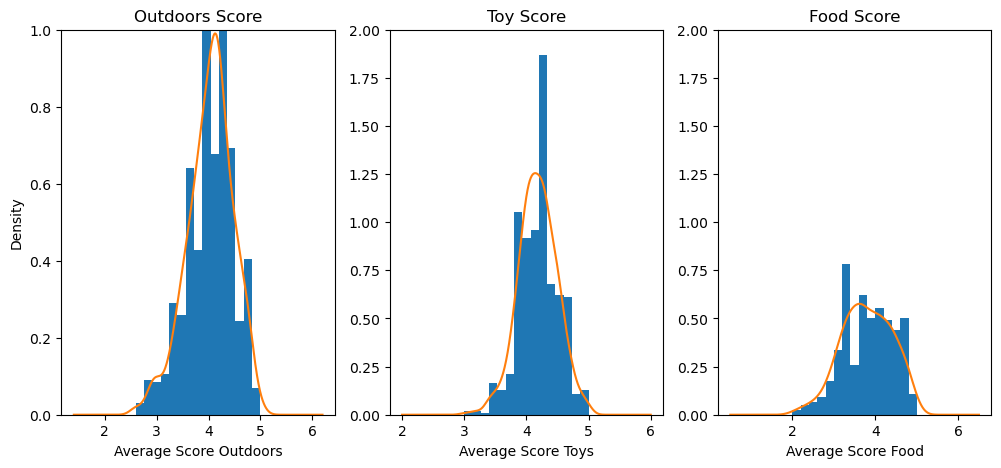

In [24]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(1, 3)

plt.figure(figsize=(12,5))

ax = plt.subplot(gs[0, 0])
data.complete_dataset['Outdoors_score'].plot(kind = "hist", density = True, bins = 15) 
data.complete_dataset['Outdoors_score'].plot(kind = "kde")
ax.set_xlabel("Average Score Outdoors")
ax.set_ylim(0, 1)
ax.set_title("Outdoors Score")


ax = plt.subplot(gs[0, 1])
data.complete_dataset['Toys_score'].plot(kind = "hist", density = True, bins = 15) 
data.complete_dataset['Toys_score'].plot(kind = "kde")
ax.set_xlabel("Average Score Toys")
ax.set_ylabel("")
ax.set_ylim(0, 2)
ax.set_title("Toy Score")


ax = plt.subplot(gs[0, 2])
data.complete_dataset['Food_score'].plot(kind = "hist", density = True, bins = 15) 
data.complete_dataset['Food_score'].plot(kind = "kde")
ax.set_xlabel("Average Score Food")
ax.set_ylabel("")
ax.set_ylim(0, 2)
ax.set_title("Food Score")

plt.show()

# Comments on the Histograms:

From the histograms, we can see that the metrics - Outdoors, Toys and Food - are all centered with a mean slightly above or below 4. Their distribution is also narrow, in the sense that there are few observations that are below 3 or close to 5.

<br><br>

<h1 style="font-size: 2.5em; background-color: #DC7D2D; padding: 1em">Machine learning models</h1>

* We will try out three types of machine learning algorithms - <b>Lasso Regression, Random Forest and Gradient Boosting</b> - for each of the three class variables - Outdoors, Toys and Food score.
* This implies that we train a total number of 3 x 3 = 9 models
* We use GridSearch to try out different values for hyperparameters
* The hyperparameters are chosen based on cross validation (part of the GridSearchCV module), with five-fold cross-validation used for Lasso and three-fold cross-validation used for Random Forest and Gradient Boosting. 
* A three-fold cross-validation is used for Random Forest and Gradient Boosting to reduce the computational load
* The best performing model for each class variable will be chosen and used in our predictions.

## Lasso

In [25]:
y = data.outdoors_regression['Outdoors_score']
X = data.outdoors_regression.iloc[ : , 1:]

lasso = Lasso(random_state=999, max_iter=10000)
alphas = np.logspace(-6, 6, 60)

tuned_parameters = [{"alpha": alphas}]
n_folds = 5

outdoors_lasso = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit="r2", scoring=["r2", "neg_mean_absolute_error"]) #"neg_mean_absolute_error"
outdoors_lasso.fit(X, y)

outdoors_lasso.MAE  = outdoors_lasso.cv_results_['mean_test_neg_mean_absolute_error'][outdoors_lasso.best_index_]
outdoors_lasso.r2 = outdoors_lasso.cv_results_['mean_test_r2'][outdoors_lasso.best_index_]

print("MAE", outdoors_lasso.MAE)
print("R2", outdoors_lasso.r2)
print(outdoors_lasso.best_estimator_)

MAE -0.33803559213059464
R2 -0.005119058923166752
Lasso(alpha=0.004581597669054491, max_iter=10000, random_state=999)


In [26]:
y = data.toys_regression['Toys_score']
X = data.toys_regression.iloc[ : , 1:]

lasso = Lasso(random_state=999, max_iter=10000)
alphas = np.logspace(-6, 6, 60)

tuned_parameters = [{"alpha": alphas}]
n_folds = 5

toys_lasso = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit="r2", scoring=["r2", "neg_mean_absolute_error"]) #"neg_mean_absolute_error"
toys_lasso.fit(X, y)

toys_lasso.MAE  = toys_lasso.cv_results_['mean_test_neg_mean_absolute_error'][toys_lasso.best_index_]
toys_lasso.r2 = toys_lasso.cv_results_['mean_test_r2'][toys_lasso.best_index_]

print("MAE", toys_lasso.MAE)
print("R2", toys_lasso.r2)
print(toys_lasso.best_estimator_)

MAE -0.22200470290453272
R2 0.1374793797351261
Lasso(alpha=0.001795714494371641, max_iter=10000, random_state=999)


In [27]:
y = data.food_regression['Food_score']
X = data.food_regression.iloc[ : , 1:]

lasso = Lasso(random_state=999, max_iter=10000)
alphas = np.logspace(-6, 6, 60)

tuned_parameters = [{"alpha": alphas}]
n_folds = 5

food_lasso = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit="r2", scoring=["r2", "neg_mean_absolute_error"]) #"neg_mean_absolute_error"
food_lasso.fit(X, y)

food_lasso.MAE  = food_lasso.cv_results_['mean_test_neg_mean_absolute_error'][food_lasso.best_index_]
food_lasso.r2 = food_lasso.cv_results_['mean_test_r2'][food_lasso.best_index_]

print("MAE", food_lasso.MAE)
print("R2", food_lasso.r2)
print(food_lasso.best_estimator_)

MAE -0.36708185011691835
R2 0.39666385497275736
Lasso(alpha=0.0004406236427773573, max_iter=10000, random_state=999)


In [28]:
data_for_table = {'Lasso R-squared': [outdoors_lasso.r2, toys_lasso.r2, food_lasso.r2], 'Lasso MAE': [-outdoors_lasso.MAE, -toys_lasso.MAE, -food_lasso.MAE]}
df_overview = pd.DataFrame(data=data_for_table, index=["Outdoors", "Toys", "Food"])
df_overview

,Lasso R-squared,Lasso MAE
Outdoors,-0.005119,0.338036
Toys,0.137479,0.222005
Food,0.396664,0.367082


## Random Forest

In [29]:
y = data.outdoors_decision_tree['Outdoors_score']
X = data.outdoors_decision_tree.iloc[ : , 1:]

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [8, 16, 40],
    'max_features': [2, 3, 6],
    'min_samples_leaf': [3, 5, 10, 15],
    'min_samples_split': [4, 8, 10, 12, 24],
    'n_estimators': [64, 128, 256]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
outdoors_random_forest = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, refit="r2", scoring=["r2", "neg_mean_absolute_error"])
outdoors_random_forest.fit(X, y)

outdoors_random_forest.MAE = outdoors_random_forest.cv_results_['mean_test_neg_mean_absolute_error'][outdoors_random_forest.best_index_]
outdoors_random_forest.r2  = outdoors_random_forest.cv_results_['mean_test_r2'][outdoors_random_forest.best_index_]

print("MAE", - outdoors_random_forest.MAE)
print("R2", outdoors_random_forest.r2)
print(outdoors_random_forest.best_estimator_)

MAE 0.3343181588132262
R2 0.02698056680444531
RandomForestRegressor(max_depth=16, max_features=3, min_samples_leaf=3,
                      min_samples_split=12, n_estimators=64)


In [30]:
y = data.toys_decision_tree['Toys_score']
X = data.toys_decision_tree.iloc[ : , 1:]

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [8, 16, 40],
    'max_features': [2, 3, 6],
    'min_samples_leaf': [3, 5, 10, 15],
    'min_samples_split': [4, 8, 10, 12, 24],
    'n_estimators': [64, 128, 256]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
toys_random_forest = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, refit="r2", scoring=["r2", "neg_mean_absolute_error"])
toys_random_forest.fit(X, y)

toys_random_forest.MAE = toys_random_forest.cv_results_['mean_test_neg_mean_absolute_error'][toys_random_forest.best_index_]
toys_random_forest.r2  = toys_random_forest.cv_results_['mean_test_r2'][toys_random_forest.best_index_]

print("MAE", toys_random_forest.MAE)
print("R2", toys_random_forest.r2)
print(toys_random_forest.best_estimator_)

MAE -0.22143917345996358
R2 0.1637679757329024
RandomForestRegressor(max_depth=40, max_features=6, min_samples_leaf=3,
                      min_samples_split=24, n_estimators=256)


In [31]:
y = data.food_decision_tree['Food_score']
X = data.food_decision_tree.iloc[ : , 1:]

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [8, 16, 40],
    'max_features': [2, 3, 6],
    'min_samples_leaf': [3, 5, 10, 15],
    'min_samples_split': [4, 8, 10, 12, 24],
    'n_estimators': [64, 128, 256]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
food_random_forest = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, refit="r2", scoring=["r2", "neg_mean_absolute_error"])
food_random_forest.fit(X, y)

food_random_forest.MAE = food_random_forest.cv_results_['mean_test_neg_mean_absolute_error'][food_random_forest.best_index_]
food_random_forest.r2  = food_random_forest.cv_results_['mean_test_r2'][food_random_forest.best_index_]

print("MAE", - food_random_forest.MAE)
print("R2", food_random_forest.r2)
print(food_random_forest.best_estimator_)

MAE 0.36821595148674885
R2 0.3997882706083176
RandomForestRegressor(max_depth=40, max_features=6, min_samples_leaf=5,
                      min_samples_split=8, n_estimators=64)


In [32]:
data_for_table['Random Forest R-squared'] = [outdoors_random_forest.r2, toys_random_forest.r2, food_random_forest.r2]
data_for_table['Random Forest MAE'] = [-outdoors_random_forest.MAE, -toys_random_forest.MAE, -food_random_forest.MAE]
df_overview = pd.DataFrame(data=data_for_table, index=["Outdoors", "Toys", "Food"])
df_overview

,Lasso R-squared,Lasso MAE,Random Forest R-squared,Random Forest MAE
Outdoors,-0.005119,0.338036,0.026981,0.334318
Toys,0.137479,0.222005,0.163768,0.221439
Food,0.396664,0.367082,0.399788,0.368216


# Gradient Boosting

In [33]:
y = data.outdoors_decision_tree['Outdoors_score']
X = data.outdoors_decision_tree.iloc[ : , 1:]

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [1, 2, 3],
    'min_samples_leaf': [3, 5, 10, 15],
    'min_samples_split': [4, 8, 10, 12, 24],
    'n_estimators': [64, 128, 256, 512, 1024],
    'learning_rate' : [0.02, 0.05]
}
# Create a based model
rf = GradientBoostingRegressor()
# Instantiate the grid search model
outdoors_boosting = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, refit="r2", scoring=["r2", "neg_mean_absolute_error"])
outdoors_boosting.fit(X, y)

outdoors_boosting.MAE = outdoors_boosting.cv_results_['mean_test_neg_mean_absolute_error'][outdoors_boosting.best_index_]
outdoors_boosting.r2  = outdoors_boosting.cv_results_['mean_test_r2'][outdoors_boosting.best_index_]

print("MAE", - outdoors_boosting.MAE)
print("R2", outdoors_boosting.r2)
print(outdoors_boosting.best_estimator_)

MAE 0.3343567759382687
R2 0.029880028016602573
GradientBoostingRegressor(learning_rate=0.05, max_depth=2, min_samples_leaf=3,
                          min_samples_split=12, n_estimators=1024)


In [34]:
y = data.toys_decision_tree['Toys_score']
X = data.toys_decision_tree.iloc[ : , 1:]

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [1, 2, 3],
    'min_samples_leaf': [3, 5, 10, 15],
    'min_samples_split': [4, 8, 10, 12, 24],
    'n_estimators': [64, 128, 256, 512, 1024],
    'learning_rate' : [0.02, 0.05]
}
# Create a based model
rf = GradientBoostingRegressor()
# Instantiate the grid search model
toys_boosting = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, refit="r2", scoring=["r2", "neg_mean_absolute_error"])
toys_boosting.fit(X, y)

toys_boosting.MAE = toys_boosting.cv_results_['mean_test_neg_mean_absolute_error'][toys_boosting.best_index_]
toys_boosting.r2  = toys_boosting.cv_results_['mean_test_r2'][toys_boosting.best_index_]

print("MAE", - toys_boosting.MAE)
print("R2", toys_boosting.r2)
print(toys_boosting.best_estimator_)

MAE 0.2215013264569622
R2 0.16499421923581267
GradientBoostingRegressor(learning_rate=0.05, max_depth=1, min_samples_leaf=3,
                          min_samples_split=4, n_estimators=1024)


In [35]:
y = data.food_decision_tree['Food_score']
X = data.food_decision_tree.iloc[ : , 1:]

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [1, 2, 3],
    'min_samples_leaf': [3, 5, 10, 15],
    'min_samples_split': [4, 8, 10, 12, 24],
    'n_estimators': [64, 128, 256, 512, 1024],
    'learning_rate' : [0.02, 0.05]
}
# Create a based model
rf = GradientBoostingRegressor()
# Instantiate the grid search model
food_boosting = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, refit="r2", scoring=["r2", "neg_mean_absolute_error"])
food_boosting.fit(X, y)

food_boosting.MAE = food_boosting.cv_results_['mean_test_neg_mean_absolute_error'][food_boosting.best_index_]
food_boosting.r2  = food_boosting.cv_results_['mean_test_r2'][food_boosting.best_index_]

print("MAE", - food_boosting.MAE)
print("R2", food_boosting.r2)
print(food_boosting.best_estimator_)

MAE 0.36927410941646516
R2 0.3906949973003037
GradientBoostingRegressor(learning_rate=0.02, min_samples_leaf=10,
                          min_samples_split=4, n_estimators=1024)


In [36]:
data_for_table['Boosting R-squared'] = [outdoors_boosting.r2, toys_boosting.r2, food_boosting.r2]
data_for_table['Boosting MAE'] = [-outdoors_boosting.MAE, -toys_boosting.MAE, -food_boosting.MAE]
df_overview = pd.DataFrame(data=data_for_table, index=["Outdoors", "Toys", "Food"])
df_overview

,Lasso R-squared,Lasso MAE,Random Forest R-squared,Random Forest MAE,Boosting R-squared,Boosting MAE
Outdoors,-0.005119,0.338036,0.026981,0.334318,0.029880,0.334357
Toys,0.137479,0.222005,0.163768,0.221439,0.164994,0.221501
Food,0.396664,0.367082,0.399788,0.368216,0.390695,0.369274


<h1 style="font-size: 2.5em; background-color: #DC7D2D; padding: 1em">Evaluation</h1>


<b>Outdoors</b>: For estimating the Outdoors score, all models performed poorly. Lasso performed even worse than using the mean of Outdoors score as the predicted value (negative R-square). Nevertheless, both Random Forest and Gradient Boosting performed better than the mean, and Gradient Boosting performed slightly better than Random Forest (0.28 vs. 0.3 R-squared).

<b>Toys</b>: For estimating the Toys score, all estimators had a positive R-squared. Again, Random Forest and Gradient Boosting performed better than Lasso Regression, and Gradient Boosting performed just slightly better than Random Forest.

<b>Food</b>: For estimating the Food score, all estimators had a fairly high and very similar R-squared. However, Random Forest performed just slightly better than Lasso and Gradient Boosting.

<b>Predictive model</b>: For our predictive model, we will use our Gradient Boosting model to predict Outdoors and Toys score and Random Forest to predict Food score.


<h1 style="font-size: 2.5em; background-color: #DC7D2D; padding: 1em">Predictive Model</h1>

We will use <b>De Ni Musene familiebarnehage</b> (The Nine Mouses Family Kindergarten) at Nordstrand as an example-case. 'De Ni Musene' has the following stats:

* Ownership : private
* Size : 10
* Borough : Nordstrand

As mentioned above, we will predict:
* Outdoors score using <b>Gradient Boosting<b> 
* Toys score using <b>Gradient Boosting<b> 
* Food score using <b>Random Forest<b>

As we can see from the results below, 'De Ni Musene' is predicted to have high scores on all three matrics.

In [37]:
X = data.transform_to_tree("private", "1-25", "Nordstrand")

In [38]:
print("Outdoor score: ", float(outdoors_boosting.predict(X).round(2)))
print("Toys score:    ", float(toys_boosting.predict(X).round(2)))
print("Food score:    ", float(food_random_forest.predict(X).round(2)))

Outdoor score:  4.46
Toys score:     4.47
Food score:     4.29


<h1 style="font-size: 2.5em; background-color: #DC7D2D; padding: 1em">Conclusion</h1>

In this notebook, we have seen that we can use the Norwegian Parent Survey for kindergartens to train machine learning models and that these machine learning models can be used to estimating the parent satisfaction level at kindergartens that are not part of the survey.